In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_dir = "/content/drive/MyDrive/PlanckDeep"
ms_output_dir = f"{drive_dir}/mukhanov_phase2"
os.makedirs(ms_output_dir, exist_ok=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

In [5]:
eta_start, eta_end = -100, -0.1
n_points = 1000
eta_vals = np.linspace(eta_start, eta_end, n_points)


def mukhanov_sasaki(eta, y, k):
    v, dv = y
    d2v = - (k**2 - 2 / eta**2) * v
    return [dv, d2v]

def initial_conditions(k, eta_0):
    v0 = np.exp(-1j * k * eta_0) / np.sqrt(2 * k)
    dv0 = -1j * k * v0
    return [v0, dv0]


In [6]:
k_vals = np.logspace(-2, 1, 10)  # from 0.01 to 10
all_data = []

for k in k_vals:
    y0 = initial_conditions(k, eta_vals[0])
    sol = solve_ivp(
        lambda eta, y: mukhanov_sasaki(eta, y, k),
        t_span=(eta_start, eta_end),
        y0=y0,
        t_eval=eta_vals,
        method='RK45'
    )
    v_k = sol.y[0]
    all_data.append({
        'k': k,
        'eta': eta_vals,
        'vk_real': np.real(v_k),
        'vk_imag': np.imag(v_k),
        'vk_abs2': np.abs(v_k)**2
    })


In [7]:
save_path = f"{ms_output_dir}/ms_solutions.npy"
np.save(save_path, all_data)
print(f"✓ Mukhanov–Sasaki solutions saved to: {save_path}")

✓ Mukhanov–Sasaki solutions saved to: /content/drive/MyDrive/PlanckDeep/mukhanov_phase2/ms_solutions.npy


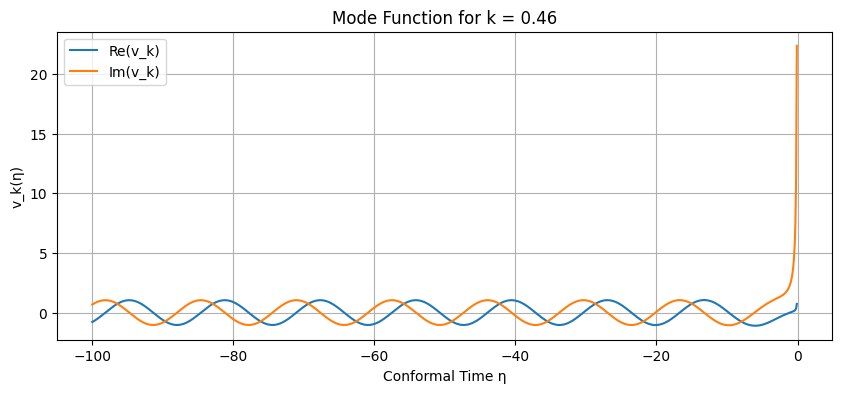

In [8]:
i = 5
plt.figure(figsize=(10, 4))
plt.plot(all_data[i]['eta'], all_data[i]['vk_real'], label='Re(v_k)')
plt.plot(all_data[i]['eta'], all_data[i]['vk_imag'], label='Im(v_k)')
plt.title(f"Mode Function for k = {all_data[i]['k']:.2f}")
plt.xlabel("Conformal Time η")
plt.ylabel("v_k(η)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [19]:
ms_data_path = "/content/drive/MyDrive/PlanckDeep/mukhanov_phase2/ms_solutions.npy"
data = np.load(ms_data_path, allow_pickle=True)


In [34]:
sample = data[5]
eta = sample["eta"]
vk_exact = sample["vk_real"]
k_val = sample["k"]

print(f"Training for k = {k_val:.3f}, η range: [{eta.min():.2f}, {eta.max():.2f}]")

Training for k = 0.464, η range: [-100.00, -0.10]


In [35]:
eta_min, eta_max = eta.min(), eta.max()
eta_norm = 2 * (eta - eta_min) / (eta_max - eta_min) - 1

In [36]:
def denormalize_eta(eta_normalized):
    return eta_min + (eta_normalized + 1) * (eta_max - eta_min) / 2

In [37]:
class EnhancedPINN(nn.Module):
    def __init__(self, hidden_size=128, num_layers=4):
        super().__init__()
        layers = []
        layers.append(nn.Linear(1, hidden_size))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)

        # Initialize weights for better convergence
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        return self.net(x)

In [38]:
def enhanced_physics_loss(model, eta_norm_tensor, k, eta_scale):
    """
    Implements: v'' + [k² - 2/η²] v = 0
    With proper chain rule for normalized coordinates
    """
    eta_norm_tensor.requires_grad_(True)

    # Convert to physical eta
    eta_phys = denormalize_eta(eta_norm_tensor)

    # Forward pass
    v = model(eta_norm_tensor)

    # First derivative: dv/dη = (dv/dη_norm) * (dη_norm/dη)
    dv_dnorm = autograd.grad(v, eta_norm_tensor, torch.ones_like(v), create_graph=True)[0]
    dv_deta = dv_dnorm * (2 / eta_scale)  # Chain rule correction

    # Second derivative
    d2v_dnorm2 = autograd.grad(dv_dnorm, eta_norm_tensor, torch.ones_like(dv_dnorm), create_graph=True)[0]
    d2v_deta2 = d2v_dnorm2 * (2 / eta_scale)**2

    # Mukhanov-Sasaki equation residual
    # Add small epsilon to avoid division by zero
    eps = 1e-10
    eta_safe = torch.where(torch.abs(eta_phys) < eps,
                          torch.sign(eta_phys) * eps,
                          eta_phys)

    residual = d2v_deta2 + (k**2 - 2 / eta_safe**2) * v

    # Weighted loss - emphasize horizon crossing region
    weights = 1.0 + 10.0 * torch.exp(-0.5 * (k * eta_phys)**2)

    return torch.mean(weights * residual**2)

In [39]:
def robust_mse_loss(model, eta_tensor, target):
    """Simplified MSE loss without complex weighting"""
    pred = model(eta_tensor)
    return nn.MSELoss()(pred, target)

In [40]:
def train_enhanced_pinn(model, eta_norm, vk_exact, k_val, eta_scale,
                       epochs=5000, lr=1e-3, physics_weight=1.0):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    eta_torch = torch.tensor(eta_norm, dtype=torch.float32).view(-1, 1).to(device)
    vk_torch = torch.tensor(vk_exact, dtype=torch.float32).view(-1, 1).to(device)

    # Debug: Print data statistics
    print(f"Data range: vk_exact ∈ [{vk_exact.min():.3f}, {vk_exact.max():.3f}]")
    print(f"Data std: {vk_exact.std():.3f}")
    print(f"eta range: [{eta_norm.min():.3f}, {eta_norm.max():.3f}]")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=300, verbose=False)

    loss_history = {'total': [], 'physics': [], 'data': []}

    print(f"Training Enhanced PINN for k = {k_val:.3f} ...")
    print(f"Device: {device}")

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute losses
        loss_phys = enhanced_physics_loss(model, eta_torch, k_val, eta_scale)
        loss_data = robust_mse_loss(model, eta_torch, vk_torch)

        # FIXED: Better adaptive weighting that actually balances losses
        if epoch < 500:
            # Phase 1: Focus on data fitting first
            data_weight = 1.0
            phys_weight = 0.001
        elif epoch < 1500:
            # Phase 2: Gradually increase physics weight
            phys_weight = 0.001 + (epoch - 500) * 0.999 / 1000
            data_weight = 1.0
        else:
            # Phase 3: Balanced training
            phys_weight = 1.0
            data_weight = 1.0

        total_loss = phys_weight * loss_phys + data_weight * loss_data

        total_loss.backward()

        # More aggressive gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)

        optimizer.step()
        scheduler.step(total_loss)

        # Store history
        loss_history['total'].append(total_loss.item())
        loss_history['physics'].append(loss_phys.item())
        loss_history['data'].append(loss_data.item())

        if epoch % 200 == 0:
            print(f"Epoch {epoch:4d}: Total = {total_loss.item():.2e} | "
                  f"Physics = {loss_phys.item():.2e} | "
                  f"Data = {loss_data.item():.2e} | "
                  f"Weights: P={phys_weight:.3f}, D={data_weight:.3f}")

    return model, loss_history

In [41]:
eta_scale = eta_max - eta_min
model = EnhancedPINN(hidden_size=64, num_layers=3)

print(f"Data diagnostics:")
print(f"k = {k_val:.3f}")
print(f"eta range: [{eta.min():.2f}, {eta.max():.2f}]")
print(f"vk_exact range: [{vk_exact.min():.3f}, {vk_exact.max():.3f}]")
print(f"vk_exact std: {vk_exact.std():.3f}")


trained_model, history = train_enhanced_pinn(
    model, eta_norm, vk_exact, k_val, eta_scale,
    epochs=2000, lr=5e-4, physics_weight=1.0  # Lower LR
)

Data diagnostics:
k = 0.464
eta range: [-100.00, -0.10]
vk_exact range: [-1.101, 1.051]
vk_exact std: 0.729
Data range: vk_exact ∈ [-1.101, 1.051]
Data std: 0.729
eta range: [-1.000, 1.000]
Training Enhanced PINN for k = 0.464 ...
Device: cpu
Epoch    0: Total = 5.31e-01 | Physics = 3.88e-01 | Data = 5.30e-01 | Weights: P=0.001, D=1.000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 5.30e-01 | Physics = 1.23e+00 | Data = 5.28e-01 | Weights: P=0.001, D=1.000
Epoch  400: Total = 5.29e-01 | Physics = 1.23e+00 | Data = 5.28e-01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 5.31e-01 | Physics = 1.02e-03 | Data = 5.31e-01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 5.33e-01 | Physics = 5.29e-03 | Data = 5.31e-01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 5.33e-01 | Physics = 4.64e-03 | Data = 5.31e-01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 5.31e-01 | Physics = 7.97e-04 | Data = 5.31e-01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 5.31e-01 | Physics = 3.07e-04 | Data = 5.31e-01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 5.37e-01 | Physics = 6.58e-03 | Data = 5.31e-01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 5.32e-01 | Physics = 1.50e-03 | Data = 5.31e-01 | Weights: P=1.000, D=1.000


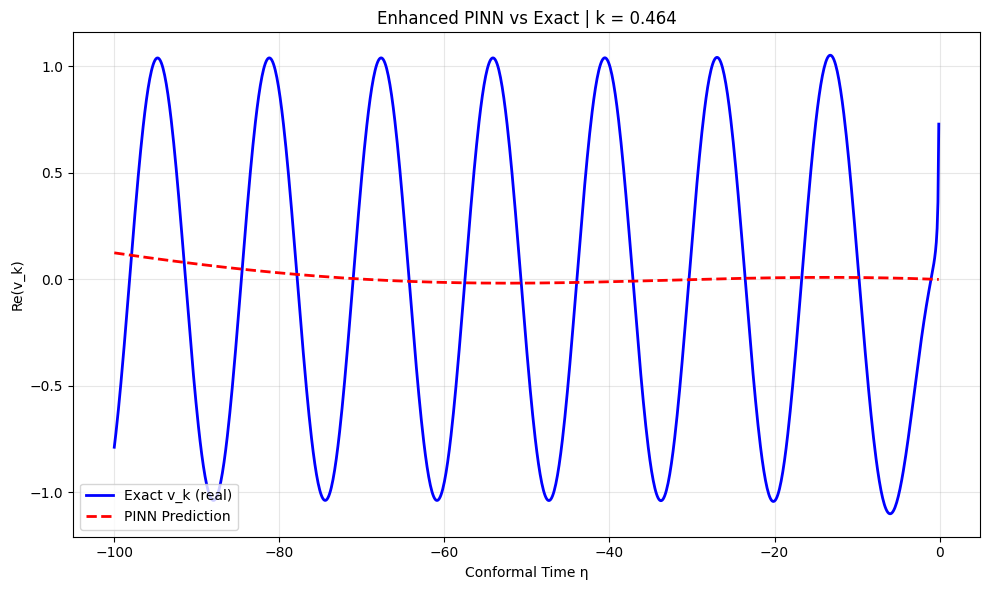

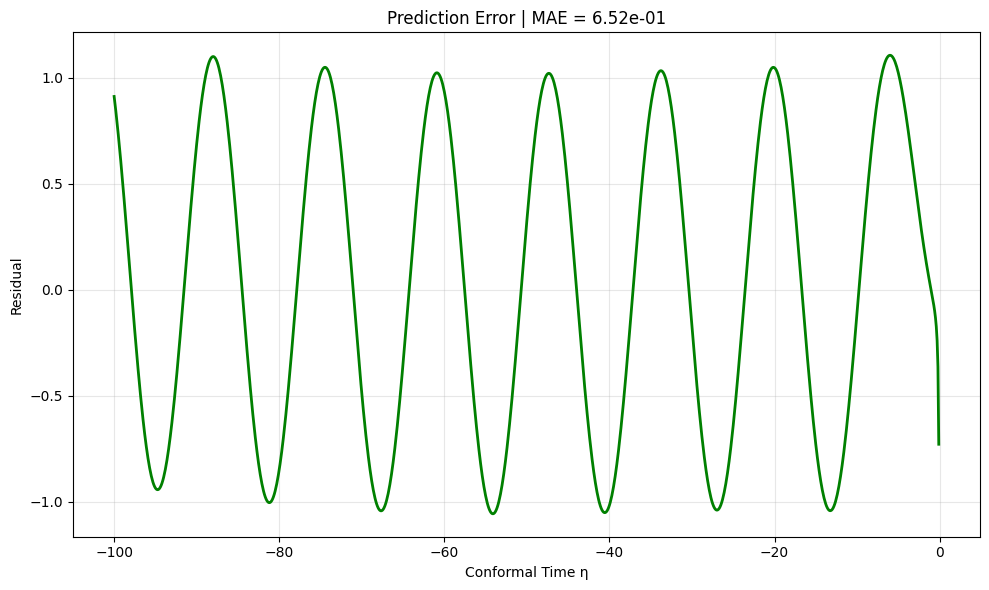

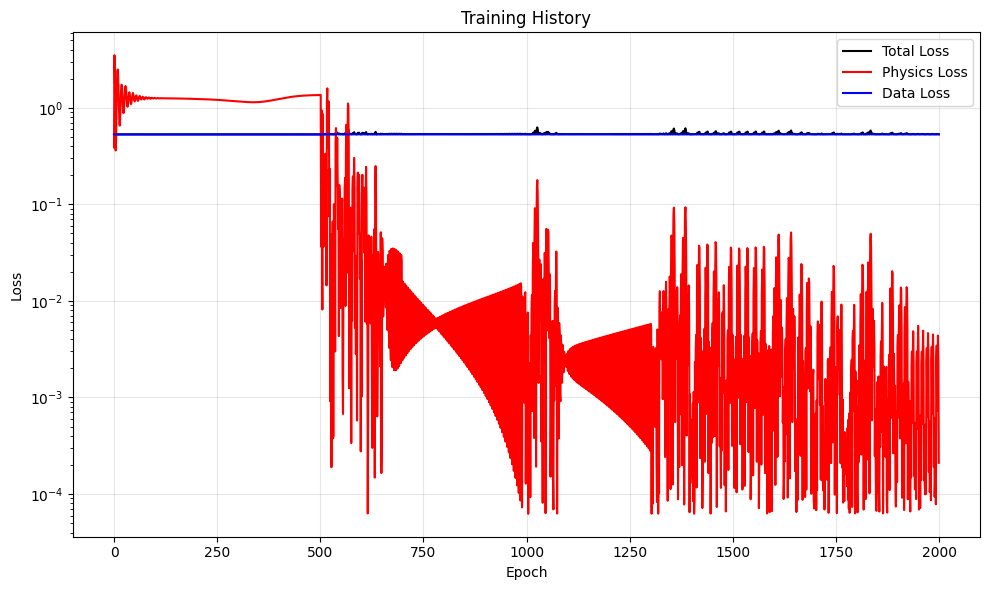

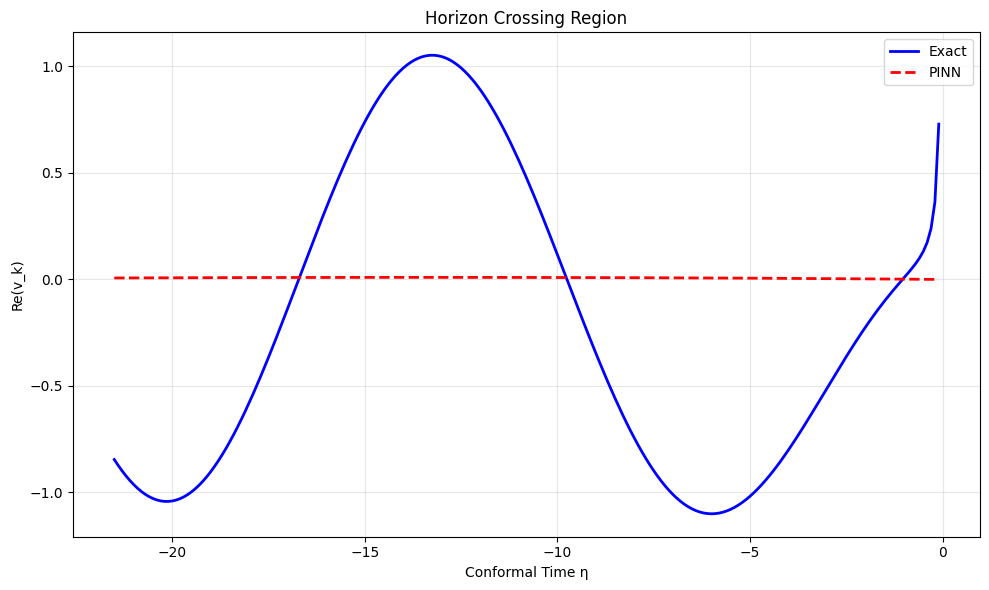

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
eta_torch = torch.tensor(eta_norm, dtype=torch.float32).view(-1, 1).to(device)

with torch.no_grad():
    pred = trained_model(eta_torch).detach().cpu().numpy().flatten()

# Calculate residual for later use
residual = pred - vk_exact

# Plot 1: Solution Comparison
plt.figure(figsize=(10, 6))
plt.plot(eta, vk_exact, 'b-', label="Exact v_k (real)", linewidth=2)
plt.plot(eta, pred, 'r--', label="PINN Prediction", linewidth=2)
plt.xlabel("Conformal Time η")
plt.ylabel("Re(v_k)")
plt.title(f"Enhanced PINN vs Exact | k = {k_val:.3f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Residual Analysis
plt.figure(figsize=(10, 6))
plt.plot(eta, residual, 'g-', linewidth=2)
plt.xlabel("Conformal Time η")
plt.ylabel("Residual")
plt.title(f"Prediction Error | MAE = {np.mean(np.abs(residual)):.2e}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Loss History
plt.figure(figsize=(10, 6))
plt.semilogy(history['total'], 'k-', label='Total Loss')
plt.semilogy(history['physics'], 'r-', label='Physics Loss')
plt.semilogy(history['data'], 'b-', label='Data Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training History")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 4: Horizon Crossing Region (zoomed)
plt.figure(figsize=(10, 6))
horizon_mask = (k_val * eta > -10) & (k_val * eta < 1)
plt.plot(eta[horizon_mask], vk_exact[horizon_mask], 'b-',
         label="Exact", linewidth=2)
plt.plot(eta[horizon_mask], pred[horizon_mask], 'r--',
         label="PINN", linewidth=2)
plt.xlabel("Conformal Time η")
plt.ylabel("Re(v_k)")
plt.title("Horizon Crossing Region")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [43]:
mse = np.mean((pred - vk_exact)**2)
mae = np.mean(np.abs(pred - vk_exact))
r2 = 1 - np.var(pred - vk_exact) / np.var(vk_exact)

print(f"\n📊 Performance Metrics:")
print(f"MSE: {mse:.2e}")
print(f"MAE: {mae:.2e}")
print(f"R²:  {r2:.4f}")
print(f"Max Error: {np.max(np.abs(residual)):.2e}")


📊 Performance Metrics:
MSE: 5.31e-01
MAE: 6.52e-01
R²:  0.0040
Max Error: 1.11e+00


In [45]:
def train_all_modes(data, start_idx=0, end_idx=None, save_dir=None):
    if end_idx is None:
        end_idx = len(data)

    all_results = []

    for i in range(start_idx, end_idx):
        sample = data[i]
        eta = sample["eta"]
        vk_exact = sample["vk_real"]
        k_val = sample["k"]

        eta_min, eta_max = eta.min(), eta.max()
        eta_norm = 2 * (eta - eta_min) / (eta_max - eta_min) - 1
        eta_scale = eta_max - eta_min

        print(f"\n🎯 Training mode {i+1}/{end_idx} | k = {k_val:.4f}")

        model = EnhancedPINN(hidden_size=64, num_layers=3)
        trained_model, history = train_enhanced_pinn(
            model, eta_norm, vk_exact, k_val, eta_scale,
            epochs=2000, lr=5e-4, physics_weight=1.0
        )

        # Evaluate
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        eta_torch = torch.tensor(eta_norm, dtype=torch.float32).view(-1, 1).to(device)
        with torch.no_grad():
            pred = trained_model(eta_torch).detach().cpu().numpy().flatten()

        mse = np.mean((pred - vk_exact)**2)
        mae = np.mean(np.abs(pred - vk_exact))
        r2 = 1 - np.var(pred - vk_exact) / np.var(vk_exact)

        result = {
            'k': float(k_val),
            'mse': float(mse),
            'mae': float(mae),
            'r2': float(r2)
        }

        all_results.append(result)

        # Optional: save model
        if save_dir:
            os.makedirs(save_dir, exist_ok=True)
            torch.save(trained_model.state_dict(), os.path.join(save_dir, f"pinn_k{i:03d}.pt"))

    return all_results


In [46]:
results = train_all_modes(data, start_idx=0, end_idx=10, save_dir="/content/drive/MyDrive/PlanckDeep/mukhanov_phase2/models")


🎯 Training mode 1/10 | k = 0.0100
Data range: vk_exact ∈ [3.821, 3856.869]
Data std: 153.653
eta range: [-1.000, 1.000]
Training Enhanced PINN for k = 0.010 ...
Device: cpu
Epoch    0: Total = 2.45e+04 | Physics = 9.41e+00 | Data = 2.45e+04 | Weights: P=0.001, D=1.000
Epoch  200: Total = 2.39e+04 | Physics = 1.19e+05 | Data = 2.38e+04 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.37e+04 | Physics = 2.74e+05 | Data = 2.35e+04 | Weights: P=0.001, D=1.000
Epoch  600: Total = 2.44e+04 | Physics = 2.98e+02 | Data = 2.44e+04 | Weights: P=0.101, D=1.000
Epoch  800: Total = 2.44e+04 | Physics = 1.05e+01 | Data = 2.44e+04 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 2.44e+04 | Physics = 3.19e+00 | Data = 2.44e+04 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 2.44e+04 | Physics = 1.58e+00 | Data = 2.44e+04 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 2.44e+04 | Physics = 1.07e+00 | Data = 2.43e+04 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 2.43e+04 | Physics = 7.03e-01 | Data =

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 2.52e+03 | Physics = 5.11e+04 | Data = 2.47e+03 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.52e+03 | Physics = 5.74e+04 | Data = 2.46e+03 | Weights: P=0.001, D=1.000
Epoch  600: Total = 2.60e+03 | Physics = 5.25e+00 | Data = 2.60e+03 | Weights: P=0.101, D=1.000
Epoch  800: Total = 2.59e+03 | Physics = 4.50e-01 | Data = 2.59e+03 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 2.58e+03 | Physics = 6.60e-01 | Data = 2.58e+03 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 2.58e+03 | Physics = 7.10e-01 | Data = 2.58e+03 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 2.58e+03 | Physics = 3.06e+00 | Data = 2.58e+03 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 2.58e+03 | Physics = 9.24e-01 | Data = 2.58e+03 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 2.58e+03 | Physics = 1.06e+00 | Data = 2.58e+03 | Weights: P=1.000, D=1.000

🎯 Training mode 3/10 | k = 0.0464
Data range: vk_exact ∈ [-3.535, 150.415]
Data std: 6.412
eta range: [-1.000, 1.000]
Training Enhanced

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 3.62e+01 | Physics = 8.30e+02 | Data = 3.54e+01 | Weights: P=0.001, D=1.000
Epoch  400: Total = 3.60e+01 | Physics = 7.65e+02 | Data = 3.53e+01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 3.70e+01 | Physics = 1.87e-02 | Data = 3.70e+01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 3.69e+01 | Physics = 4.25e-03 | Data = 3.69e+01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 3.70e+01 | Physics = 1.07e-02 | Data = 3.70e+01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 3.69e+01 | Physics = 5.53e-03 | Data = 3.69e+01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 3.70e+01 | Physics = 1.13e-01 | Data = 3.69e+01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 3.69e+01 | Physics = 5.72e-03 | Data = 3.69e+01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 3.70e+01 | Physics = 3.13e-02 | Data = 3.69e+01 | Weights: P=1.000, D=1.000

🎯 Training mode 4/10 | k = 0.1000
Data range: vk_exact ∈ [-2.361, 21.738]
Data std: 1.778
eta range: [-1.000, 1.000]
Training Enhanced 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 1.14e+00 | Physics = 7.82e+00 | Data = 1.13e+00 | Weights: P=0.001, D=1.000
Epoch  400: Total = 1.13e+00 | Physics = 6.03e+00 | Data = 1.13e+00 | Weights: P=0.001, D=1.000
Epoch  600: Total = 1.15e+00 | Physics = 1.36e-01 | Data = 1.14e+00 | Weights: P=0.101, D=1.000
Epoch  800: Total = 1.18e+00 | Physics = 1.14e-01 | Data = 1.14e+00 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 1.16e+00 | Physics = 3.87e-02 | Data = 1.14e+00 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 1.18e+00 | Physics = 5.71e-02 | Data = 1.14e+00 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 1.19e+00 | Physics = 5.09e-02 | Data = 1.14e+00 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 1.14e+00 | Physics = 2.38e-03 | Data = 1.14e+00 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 1.14e+00 | Physics = 2.00e-03 | Data = 1.14e+00 | Weights: P=1.000, D=1.000

🎯 Training mode 6/10 | k = 0.4642
Data range: vk_exact ∈ [-1.101, 1.051]
Data std: 0.729
eta range: [-1.000, 1.000]
Training Enhanced P

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 5.30e-01 | Physics = 1.24e+00 | Data = 5.29e-01 | Weights: P=0.001, D=1.000
Epoch  400: Total = 5.30e-01 | Physics = 1.23e+00 | Data = 5.29e-01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 5.35e-01 | Physics = 3.17e-02 | Data = 5.32e-01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 5.32e-01 | Physics = 2.56e-04 | Data = 5.32e-01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 5.32e-01 | Physics = 1.04e-03 | Data = 5.31e-01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 5.32e-01 | Physics = 1.29e-03 | Data = 5.31e-01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 5.34e-01 | Physics = 2.59e-03 | Data = 5.31e-01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 5.32e-01 | Physics = 7.89e-04 | Data = 5.31e-01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 5.33e-01 | Physics = 1.64e-03 | Data = 5.31e-01 | Weights: P=1.000, D=1.000

🎯 Training mode 7/10 | k = 1.0000
Data range: vk_exact ∈ [-0.749, 0.714]
Data std: 0.498
eta range: [-1.000, 1.000]
Training Enhanced P

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 2.48e-01 | Physics = 7.04e-02 | Data = 2.48e-01 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.48e-01 | Physics = 7.99e-02 | Data = 2.48e-01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 2.49e-01 | Physics = 1.46e-03 | Data = 2.48e-01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 2.51e-01 | Physics = 7.33e-03 | Data = 2.48e-01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 2.50e-01 | Physics = 3.50e-03 | Data = 2.48e-01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 2.50e-01 | Physics = 2.11e-03 | Data = 2.48e-01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 2.49e-01 | Physics = 3.21e-04 | Data = 2.48e-01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 2.48e-01 | Physics = 1.65e-05 | Data = 2.48e-01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 2.48e-01 | Physics = 1.07e-04 | Data = 2.48e-01 | Weights: P=1.000, D=1.000

🎯 Training mode 8/10 | k = 2.1544
Data range: vk_exact ∈ [-0.508, 0.485]
Data std: 0.340
eta range: [-1.000, 1.000]
Training Enhanced P

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 1.15e-01 | Physics = 1.58e-02 | Data = 1.15e-01 | Weights: P=0.001, D=1.000
Epoch  400: Total = 1.15e-01 | Physics = 1.59e-02 | Data = 1.15e-01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 1.16e-01 | Physics = 3.71e-03 | Data = 1.15e-01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 1.18e-01 | Physics = 8.55e-03 | Data = 1.15e-01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 1.17e-01 | Physics = 2.79e-03 | Data = 1.15e-01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 1.17e-01 | Physics = 2.93e-03 | Data = 1.15e-01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 1.16e-01 | Physics = 2.85e-04 | Data = 1.15e-01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 1.16e-01 | Physics = 1.69e-04 | Data = 1.15e-01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 1.15e-01 | Physics = 1.30e-04 | Data = 1.15e-01 | Weights: P=1.000, D=1.000

🎯 Training mode 9/10 | k = 4.6416
Data range: vk_exact ∈ [-0.342, 0.328]
Data std: 0.231
eta range: [-1.000, 1.000]
Training Enhanced P

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 5.33e-02 | Physics = 1.15e-03 | Data = 5.33e-02 | Weights: P=0.001, D=1.000
Epoch  400: Total = 5.33e-02 | Physics = 1.28e-03 | Data = 5.33e-02 | Weights: P=0.001, D=1.000
Epoch  600: Total = 5.42e-02 | Physics = 9.34e-03 | Data = 5.33e-02 | Weights: P=0.101, D=1.000
Epoch  800: Total = 6.62e-02 | Physics = 4.28e-02 | Data = 5.33e-02 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 6.09e-02 | Physics = 1.52e-02 | Data = 5.33e-02 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 6.33e-02 | Physics = 1.42e-02 | Data = 5.33e-02 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 6.59e-02 | Physics = 1.40e-02 | Data = 5.33e-02 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 5.93e-02 | Physics = 6.00e-03 | Data = 5.33e-02 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 5.94e-02 | Physics = 6.08e-03 | Data = 5.33e-02 | Weights: P=1.000, D=1.000

🎯 Training mode 10/10 | k = 10.0000
Data range: vk_exact ∈ [-0.230, 0.224]
Data std: 0.156
eta range: [-1.000, 1.000]
Training Enhanced

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 2.45e-02 | Physics = 6.49e-03 | Data = 2.45e-02 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.45e-02 | Physics = 5.11e-03 | Data = 2.45e-02 | Weights: P=0.001, D=1.000
Epoch  600: Total = 1.12e-01 | Physics = 8.62e-01 | Data = 2.45e-02 | Weights: P=0.101, D=1.000
Epoch  800: Total = 2.86e-02 | Physics = 1.38e-02 | Data = 2.45e-02 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 5.40e-02 | Physics = 5.90e-02 | Data = 2.45e-02 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 3.70e-02 | Physics = 1.78e-02 | Data = 2.45e-02 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 3.22e-02 | Physics = 8.56e-03 | Data = 2.45e-02 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 3.11e-02 | Physics = 6.67e-03 | Data = 2.45e-02 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 2.91e-02 | Physics = 4.67e-03 | Data = 2.45e-02 | Weights: P=1.000, D=1.000


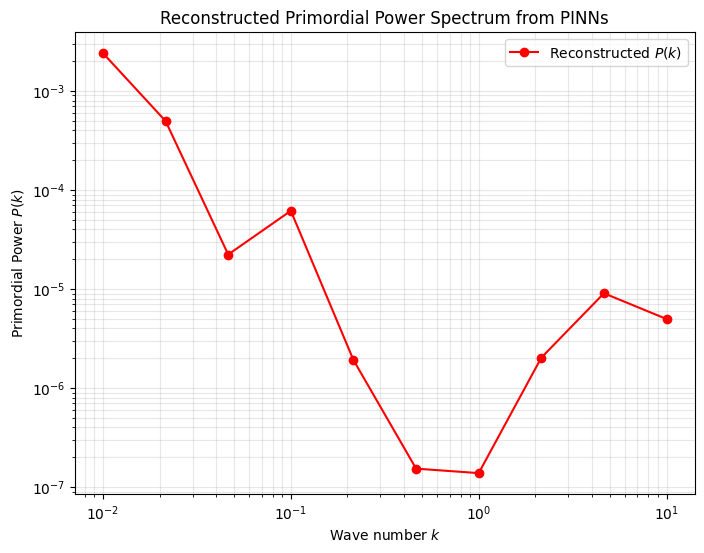

In [51]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Evaluate all models at η = 0⁻ (last η point)
eta_eval_norm = torch.tensor([[1.0]], dtype=torch.float32)  # normalized η = +1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p_k_values = []
k_values = []

for i, sample in enumerate(data[:10]):
    k_val = sample['k']
    eta_min, eta_max = sample['eta'].min(), sample['eta'].max()
    eta_scale = eta_max - eta_min

    # Load or reuse model
    model = EnhancedPINN(hidden_size=64, num_layers=3)
    path = f"/content/drive/MyDrive/PlanckDeep/mukhanov_phase2/models/pinn_k{i:03d}.pt"
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        v_pred = model(eta_eval_norm.to(device)).cpu().numpy().flatten()[0]
        p_k = np.abs(v_pred)**2
        p_k_values.append(p_k)
        k_values.append(k_val)

# Sort results
k_values = np.array(k_values)
p_k_values = np.array(p_k_values)
sort_idx = np.argsort(k_values)

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(k_values[sort_idx], p_k_values[sort_idx], 'ro-', label="Reconstructed $P(k)$")
plt.xlabel("Wave number $k$")
plt.ylabel("Primordial Power $P(k)$")
plt.title("Reconstructed Primordial Power Spectrum from PINNs")
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.show()


In [50]:
train_all_modes(data, start_idx=0, end_idx=30)


🎯 Training mode 1/30 | k = 0.0100
Data range: vk_exact ∈ [3.821, 3856.869]
Data std: 153.653
eta range: [-1.000, 1.000]
Training Enhanced PINN for k = 0.010 ...
Device: cpu
Epoch    0: Total = 2.45e+04 | Physics = 6.12e-01 | Data = 2.45e+04 | Weights: P=0.001, D=1.000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 2.39e+04 | Physics = 1.06e+05 | Data = 2.38e+04 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.37e+04 | Physics = 2.54e+05 | Data = 2.35e+04 | Weights: P=0.001, D=1.000
Epoch  600: Total = 2.44e+04 | Physics = 1.87e+02 | Data = 2.44e+04 | Weights: P=0.101, D=1.000
Epoch  800: Total = 2.44e+04 | Physics = 1.09e+01 | Data = 2.44e+04 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 2.44e+04 | Physics = 3.33e+00 | Data = 2.44e+04 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 2.44e+04 | Physics = 1.67e+00 | Data = 2.44e+04 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 2.43e+04 | Physics = 1.18e+00 | Data = 2.43e+04 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 2.43e+04 | Physics = 1.08e+00 | Data = 2.43e+04 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 2.43e+04 | Physics = 1.30e+00 | Data = 2.43e+04 | Weights: P=1.000, D=1.000

🎯 Training mode 2/30 | k = 0.0215
Data range: vk_exact ∈ [-2.655, 1259.666]
Data std: 50.380
eta range: [-1.000, 1.000]
Training Enhanc

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 2.52e+03 | Physics = 5.08e+04 | Data = 2.47e+03 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.52e+03 | Physics = 5.74e+04 | Data = 2.46e+03 | Weights: P=0.001, D=1.000
Epoch  600: Total = 2.60e+03 | Physics = 1.05e-01 | Data = 2.60e+03 | Weights: P=0.101, D=1.000
Epoch  800: Total = 2.58e+03 | Physics = 2.37e+00 | Data = 2.58e+03 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 2.58e+03 | Physics = 1.18e+00 | Data = 2.58e+03 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 2.58e+03 | Physics = 7.17e-01 | Data = 2.58e+03 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 2.58e+03 | Physics = 9.17e-01 | Data = 2.58e+03 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 2.58e+03 | Physics = 9.77e-01 | Data = 2.58e+03 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 2.58e+03 | Physics = 1.65e+00 | Data = 2.58e+03 | Weights: P=1.000, D=1.000

🎯 Training mode 3/30 | k = 0.0464
Data range: vk_exact ∈ [-3.535, 150.415]
Data std: 6.412
eta range: [-1.000, 1.000]
Training Enhanced

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 3.62e+01 | Physics = 7.99e+02 | Data = 3.54e+01 | Weights: P=0.001, D=1.000
Epoch  400: Total = 3.60e+01 | Physics = 7.68e+02 | Data = 3.53e+01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 3.71e+01 | Physics = 2.64e+00 | Data = 3.68e+01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 3.70e+01 | Physics = 2.01e-01 | Data = 3.69e+01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 3.70e+01 | Physics = 1.93e-01 | Data = 3.69e+01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 3.70e+01 | Physics = 3.97e-03 | Data = 3.69e+01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 3.70e+01 | Physics = 8.26e-03 | Data = 3.70e+01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 3.70e+01 | Physics = 2.23e-02 | Data = 3.69e+01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 3.70e+01 | Physics = 6.17e-03 | Data = 3.69e+01 | Weights: P=1.000, D=1.000

🎯 Training mode 4/30 | k = 0.1000
Data range: vk_exact ∈ [-2.361, 21.738]
Data std: 1.778
eta range: [-1.000, 1.000]
Training Enhanced 

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 1.91e+00 | Physics = 1.37e+00 | Data = 1.91e+00 | Weights: P=0.001, D=1.000
Epoch  400: Total = 9.29e-01 | Physics = 3.99e+01 | Data = 8.89e-01 | Weights: P=0.001, D=1.000
Epoch  600: Total = 9.03e-01 | Physics = 2.11e-01 | Data = 8.82e-01 | Weights: P=0.101, D=1.000
Epoch  800: Total = 8.88e-01 | Physics = 8.00e-03 | Data = 8.86e-01 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 1.08e+00 | Physics = 3.70e-01 | Data = 8.91e-01 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 9.17e-01 | Physics = 4.49e-02 | Data = 8.85e-01 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 9.48e-01 | Physics = 7.59e-02 | Data = 8.80e-01 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 1.02e+00 | Physics = 1.32e-01 | Data = 8.87e-01 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 9.10e-01 | Physics = 2.62e-02 | Data = 8.84e-01 | Weights: P=1.000, D=1.000

🎯 Training mode 5/30 | k = 0.2154
Data range: vk_exact ∈ [-1.614, 3.673]
Data std: 1.071
eta range: [-1.000, 1.000]
Training Enhanced P

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 1.14e+00 | Physics = 7.63e+00 | Data = 1.13e+00 | Weights: P=0.001, D=1.000
Epoch  400: Total = 1.13e+00 | Physics = 6.17e+00 | Data = 1.13e+00 | Weights: P=0.001, D=1.000
Epoch  600: Total = 1.20e+00 | Physics = 5.33e-01 | Data = 1.15e+00 | Weights: P=0.101, D=1.000
Epoch  800: Total = 1.15e+00 | Physics = 2.63e-02 | Data = 1.14e+00 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 1.14e+00 | Physics = 2.50e-03 | Data = 1.14e+00 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 1.14e+00 | Physics = 1.03e-03 | Data = 1.14e+00 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 1.14e+00 | Physics = 1.23e-03 | Data = 1.14e+00 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 1.14e+00 | Physics = 4.36e-03 | Data = 1.14e+00 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 1.14e+00 | Physics = 1.67e-03 | Data = 1.14e+00 | Weights: P=1.000, D=1.000

🎯 Training mode 6/30 | k = 0.4642
Data range: vk_exact ∈ [-1.101, 1.051]
Data std: 0.729
eta range: [-1.000, 1.000]
Training Enhanced P

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 5.33e-02 | Physics = 5.30e-04 | Data = 5.33e-02 | Weights: P=0.001, D=1.000
Epoch  400: Total = 5.33e-02 | Physics = 6.51e-04 | Data = 5.33e-02 | Weights: P=0.001, D=1.000
Epoch  600: Total = 5.89e-02 | Physics = 5.56e-02 | Data = 5.33e-02 | Weights: P=0.101, D=1.000
Epoch  800: Total = 5.36e-02 | Physics = 9.44e-04 | Data = 5.33e-02 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 5.42e-02 | Physics = 1.87e-03 | Data = 5.33e-02 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 5.42e-02 | Physics = 1.25e-03 | Data = 5.33e-02 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 5.54e-02 | Physics = 2.37e-03 | Data = 5.33e-02 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 5.33e-02 | Physics = 2.10e-05 | Data = 5.33e-02 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 5.36e-02 | Physics = 3.18e-04 | Data = 5.33e-02 | Weights: P=1.000, D=1.000

🎯 Training mode 10/30 | k = 10.0000
Data range: vk_exact ∈ [-0.230, 0.224]
Data std: 0.156
eta range: [-1.000, 1.000]
Training Enhanced

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch  200: Total = 2.45e-02 | Physics = 5.25e-04 | Data = 2.45e-02 | Weights: P=0.001, D=1.000
Epoch  400: Total = 2.45e-02 | Physics = 3.55e-04 | Data = 2.45e-02 | Weights: P=0.001, D=1.000
Epoch  600: Total = 3.79e-02 | Physics = 1.33e-01 | Data = 2.45e-02 | Weights: P=0.101, D=1.000
Epoch  800: Total = 1.04e-01 | Physics = 2.65e-01 | Data = 2.45e-02 | Weights: P=0.301, D=1.000
Epoch 1000: Total = 3.80e-02 | Physics = 2.70e-02 | Data = 2.45e-02 | Weights: P=0.500, D=1.000
Epoch 1200: Total = 4.06e-02 | Physics = 2.30e-02 | Data = 2.45e-02 | Weights: P=0.700, D=1.000
Epoch 1400: Total = 3.28e-02 | Physics = 9.26e-03 | Data = 2.45e-02 | Weights: P=0.900, D=1.000
Epoch 1600: Total = 2.73e-02 | Physics = 2.83e-03 | Data = 2.45e-02 | Weights: P=1.000, D=1.000
Epoch 1800: Total = 2.77e-02 | Physics = 3.23e-03 | Data = 2.45e-02 | Weights: P=1.000, D=1.000


IndexError: index 10 is out of bounds for axis 0 with size 10